# SED Processing Testing V2
This is an extension of the previous notebook which tests the functions that have been developed for processing and creating composite SEDS
The ides is that these functions will be useable enough, and will be flexible enough to allow for resuseability with different SEDs and with different AGN models

In [88]:
# Import in all of the required libraries
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import pandas as pd
import os
from astLib import astSED
import astropy.io.fits as fits
from carf import * # custom module for functions relating to the project

# So that we can change the helper functions without reloading the kernel
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
# setup all the directories we are getting our data from 

# Skirtor models
skirtor_folderpath = os.path.join('datasets', 'Templates', 'Skirtor')

# Swire templates
swire_folderpath = os.path.join('datasets', 'Templates', 'SWIRE')

# Brown templates
brown_folderpath = os.path.join('datasets', 'Templates', 'Brown', '2014','Rest')

# Filters
pb_U_path = os.path.join('datasets', 'Filters', 'Generic_Johnson.U.dat')
pb_V_path = os.path.join('datasets', 'Filters', 'Generic_Johnson.V.dat')
pb_J_path = os.path.join('datasets', 'Filters', '2MASS_2MASS.J.dat')

# SWIRE + Skirtor Composite SEDs
This part of the document aims to test the combining proccess of the Skirtor AGN models, with the SWIRE templates. These templates have a shortened wavelength range so the functionality in the helper package should make sure these are both compatible and allow for composite seds to be made.


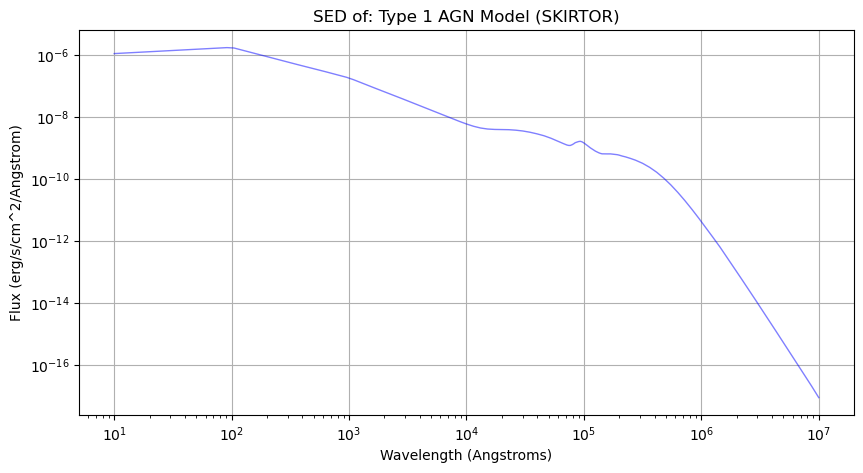

In [90]:
# Begin by attempting to create a composite of just 1 model
# For this we will define a type 1 agn model using the appropriate Skirtor parameters
# Begin by importing the first AGN model we would like to use
# 1. Type 1 AGN
tau = SKIRTOR_PARAMS['tau'][3]
p = SKIRTOR_PARAMS['p'][0]
q = SKIRTOR_PARAMS['q'][0]
oa = SKIRTOR_PARAMS['oa'][4]
rr = SKIRTOR_PARAMS['rr'][2]
i = SKIRTOR_PARAMS['i'][0]

agn_model = read_skirtor_model(skirtor_folderpath, tau, p, q, oa, rr, i)
wl_agn = agn_model['lambda (Angstroms)']
fl_agn = agn_model['Total Flux (erg/s/cm^2/Angstrom)']

# plot the agn model
plot_galaxy_sed(wl_agn, fl_agn, "Type 1 AGN Model", "SKIRTOR")

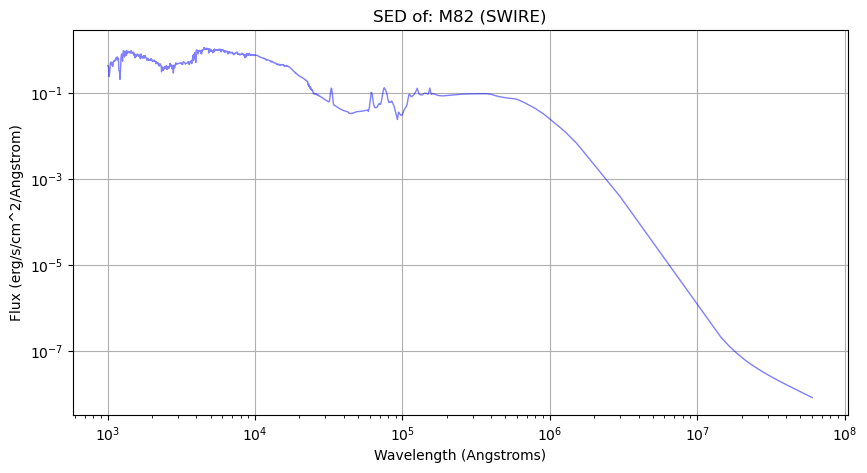

In [91]:
# Similarly we can plot a single swire template, we will use M82
m82_template, objname = read_swire_template(swire_folderpath, 'M82')
m82_template


wl_m82 = m82_template['lambda (Angstroms)']
fl_m82 = m82_template['Total Flux (erg/s/cm^2/Angstrom)']

# Plot the SED of M82
plot_galaxy_sed(wl_m82, fl_m82, 'M82', 'SWIRE')

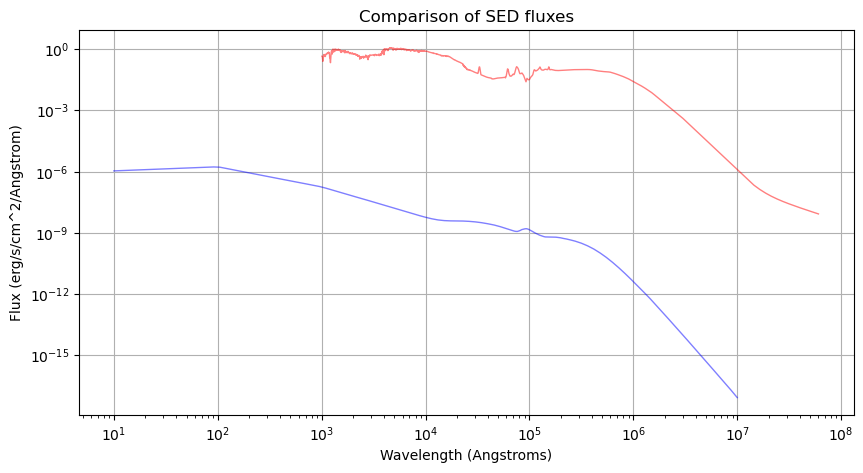

In [92]:
plt.figure(figsize=(10, 5))
plt.loglog(wl_m82, fl_m82, color='red', linewidth=1, linestyle='-', alpha=0.5)
plt.loglog(wl_agn, fl_agn, color='blue', linewidth=1, linestyle='-', alpha=0.5)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('Comparison of SED fluxes')
plt.grid()
plt.show()

From the graph above it is obvious that we can se that both of these SEDs don't exactly align in a way that will make sense or work for us. To rectify this we need to make sure that both of these SEDs exsist over the same wavelength range (are interpolated over a set of combined wavelengths, and are also within the same range of values. We see that the AGN has a lot more values in the shorter wavelength range, so for this to work this information must be cut off. This may be a limitation in the SWIRE templates but further investigation is needed. Our step now is to correct the wavelength range for these two SEDS

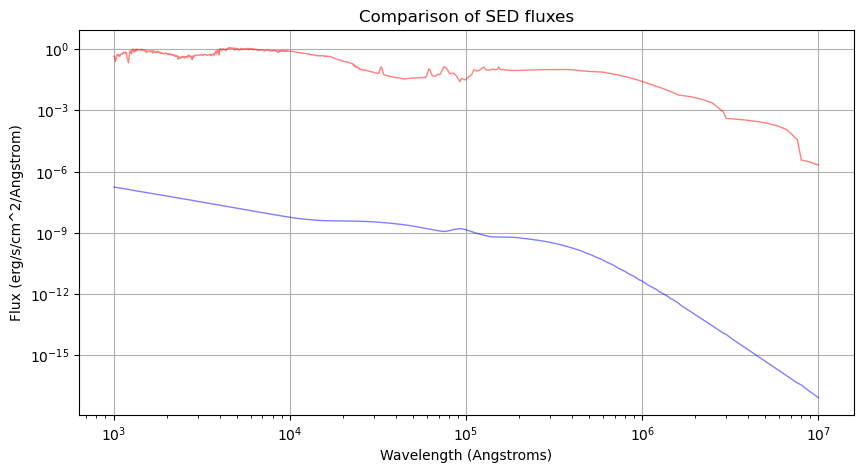

In [93]:
# We use our function two change the wavelenth range of the two SEDs, rectifying any missing wavelength values
m82_template, agn_model = adjust_wavelength_range(m82_template, agn_model)

# We can now attempt to replot these both on the same graph
wl_m82 = m82_template['lambda (Angstroms)']
fl_m82 = m82_template['Total Flux (erg/s/cm^2/Angstrom)']
wl_agn = agn_model['lambda (Angstroms)']
fl_agn = agn_model['Total Flux (erg/s/cm^2/Angstrom)']


# Plotting the adjusted SEDS
plt.figure(figsize=(10, 5))
plt.loglog(wl_m82, fl_m82, color='red', linewidth=1, linestyle='-', alpha=0.5)
plt.loglog(wl_agn, fl_agn, color='blue', linewidth=1, linestyle='-', alpha=0.5)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('Comparison of SED fluxes')
plt.grid()
plt.show()

We can see that this has correctly put the SEDs into the same wavelength range and in addition to this have made both of the SEDs compareable in the wavelength range. Now we need to make sure that we get the fluxes to be comparable. We do this by integrating the fluxes across the wavelength range, and then perform a normalization based on the integral of the flux.

In [94]:
# We now perform integral normalization on both of the SEDS
agn_model = normalize_flux_integral(agn_model)
m82_template = normalize_flux_integral(m82_template)



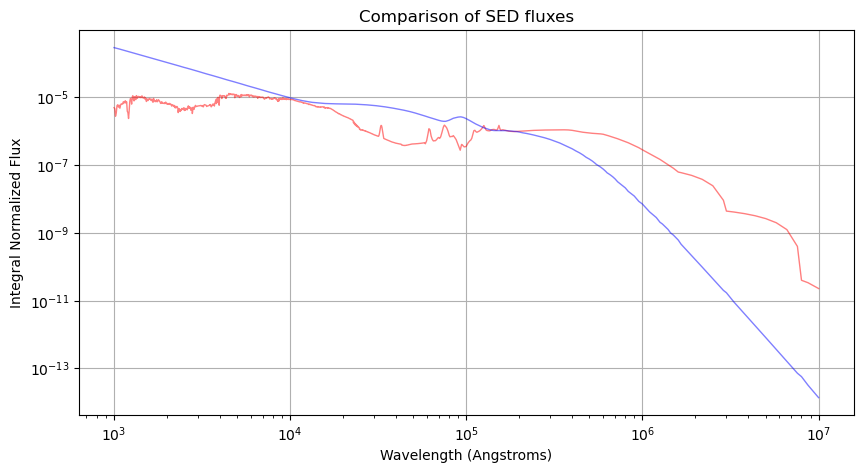

In [95]:
# We can attempt to plot these again 

# We can now attempt to replot these both on the same graph
wl_m82 = m82_template['lambda (Angstroms)']
fl_m82 = m82_template['integral normalized flux']
wl_agn = agn_model['lambda (Angstroms)']
fl_agn = agn_model['integral normalized flux']


# Plotting the adjusted SEDS
plt.figure(figsize=(10, 5))
plt.loglog(wl_m82, fl_m82, color='red', linewidth=1, linestyle='-', alpha=0.5)
plt.loglog(wl_agn, fl_agn, color='blue', linewidth=1, linestyle='-', alpha=0.5)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Integral Normalized Flux')
plt.title('Comparison of SED fluxes')
plt.grid()
plt.show()

In [96]:
# Now that we have a galaxy and a AGN which have integral normalized flux units, we can use our code to create composite agn+galaxies
# We begin with the example above

# Create an entirely new composite galaxy() with params alpha = 0.5, beta is default to 1, but set to (1-alpha for this)
# thus this is an galaxy composite created through sed addition: 50% AGN, 50% M82 (Starburst)
alpha = 0.5
agn_starburst_composite = create_gal_agn_composite_sed(agn_model, m82_template, alpha, (1-alpha))


agn_starburst_composite


      lambda (Angstroms)  Total Flux (erg/s/cm^2/Angstrom)  \
0                    1.0                      2.532648e+06   
1                    1.0                      2.406852e+06   
2                    1.0                      1.454412e+06   
3                    1.0                      1.842030e+06   
4                    1.0                      3.067915e+06   
...                  ...                               ...   
1291                 1.0                      1.117211e+12   
1292                 1.0                      8.021924e+11   
1293                 1.0                      1.015922e+11   
1294                 1.0                      1.539031e+11   
1295                 1.0                      2.411141e+11   

      integral normalized flux  
0                     0.017076  
1                     0.016228  
2                     0.009806  
3                     0.012420  
4                     0.020685  
...                        ...  
1291               7532.

ValueError: Columns must be same length as key

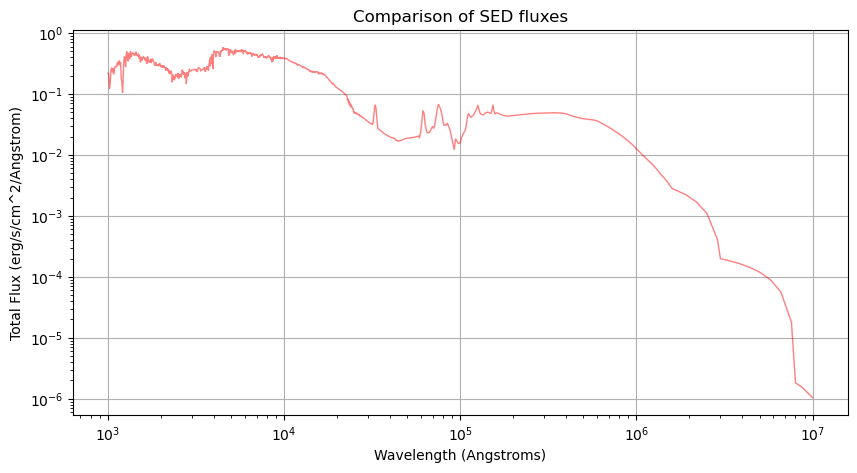

In [97]:
# We can now plot this composite
wl_comp = agn_starburst_composite['lambda (Angstroms)']
fl_comp = agn_starburst_composite['Total Flux (erg/s/cm^2/Angstrom)']


# Plotting the adjusted SEDS
plt.figure(figsize=(10, 5))
plt.loglog(wl_comp, fl_comp, color='red', linewidth=1, linestyle='-', alpha=0.5)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Total Flux (erg/s/cm^2/Angstrom)')
plt.title('Comparison of SED fluxes')
plt.grid()
plt.show()

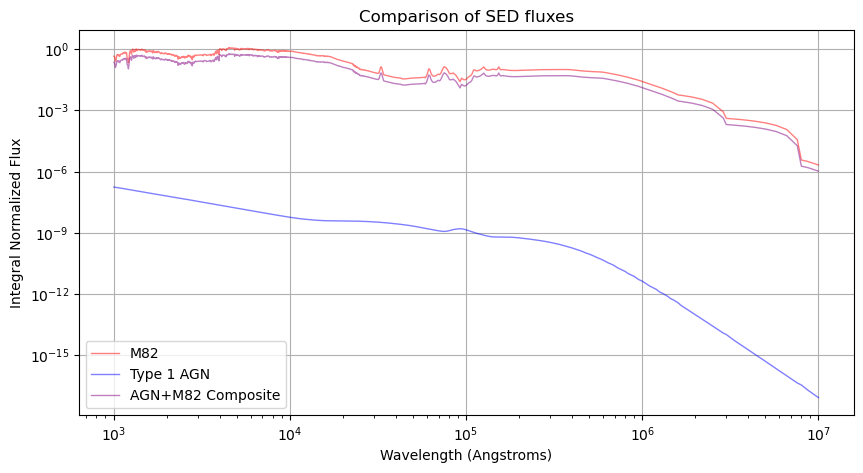

In [98]:
# Plotting this with it's component AGN bits
# We can now attempt to replot these both on the same graph
wl_m82 = m82_template['lambda (Angstroms)']
fl_m82 = m82_template['Total Flux (erg/s/cm^2/Angstrom)']
wl_agn = agn_model['lambda (Angstroms)']
fl_agn = agn_model['Total Flux (erg/s/cm^2/Angstrom)']


# Plotting the adjusted SEDS
plt.figure(figsize=(10, 5))
plt.loglog(wl_m82, fl_m82, color='red', linewidth=1, linestyle='-', alpha=0.5, label='M82')
plt.loglog(wl_agn, fl_agn, color='blue', linewidth=1, linestyle='-', alpha=0.5, label='Type 1 AGN')
plt.loglog(wl_comp, fl_comp, color='purple', linewidth=1, linestyle='-', alpha=0.5, label='AGN+M82 Composite')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Integral Normalized Flux')
plt.title('Comparison of SED fluxes')
plt.grid()
plt.legend()
plt.show()

In [101]:
# Now we see exactly how these work we also note that this is not what we want
# We again try but instead we use a scaling factor derived from the galaxy to determine how to scale the AGN


# We attempt this using the parameters alpha = 0.5, beta = 1
# where the scaling is done internally in the function
alpha = 0.5
agn_starburst_composite_add = create_gal_agn_composite_sed(agn_model, m82_template, alpha)
agn_starburst_composite_add

148315843.9357528


,lambda (Angstroms),Total Flux (erg/s/cm^2/Angstrom)
0,1005.00,13.289631
1,1015.00,13.103019
2,1025.00,12.777259
3,1035.00,12.679163
4,1045.00,12.717443
...,...,...
1291,6606934.48,0.000113
1292,7585775.75,0.000036
1293,8000000.00,0.000004
1294,8709635.90,0.000003


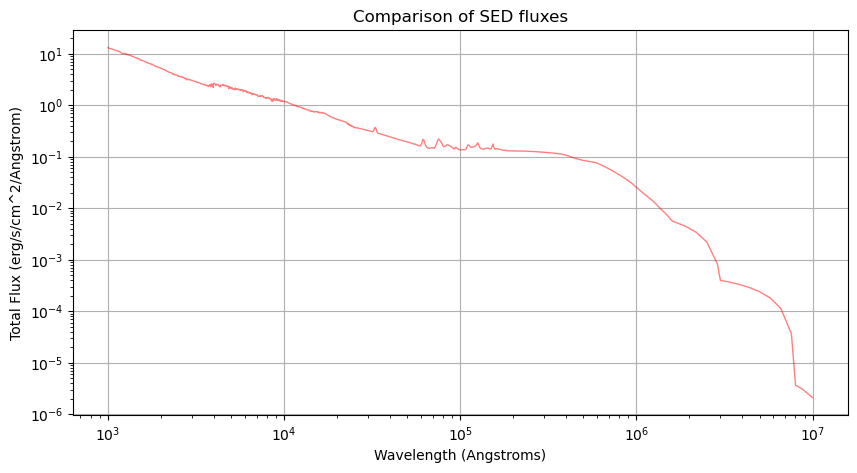

In [102]:
# We can now attempt to plot this
wl_comp = agn_starburst_composite_add['lambda (Angstroms)']
fl_comp = agn_starburst_composite_add['Total Flux (erg/s/cm^2/Angstrom)']

# Plotting the adjusted SEDS
plt.figure(figsize=(10, 5))
plt.loglog(wl_comp, fl_comp, color='red', linewidth=1, linestyle='-', alpha=0.5)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Total Flux (erg/s/cm^2/Angstrom)')
plt.title('Comparison of SED fluxes')
plt.grid()
plt.show()


In [123]:
# We attempt this method with multiple different values of alpha
alpha = np.linspace(0, 1, 6)

In [124]:
alpha

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

Creating composite with alpha = 0.0
1.0
Creating composite with alpha = 0.2
1.0
Creating composite with alpha = 0.4
1.0
Creating composite with alpha = 0.6000000000000001
1.0
Creating composite with alpha = 0.8
1.0
Creating composite with alpha = 1.0
1.0


Text(0, 0.5, 'Total Flux (erg/s/cm^2/Angstrom)')

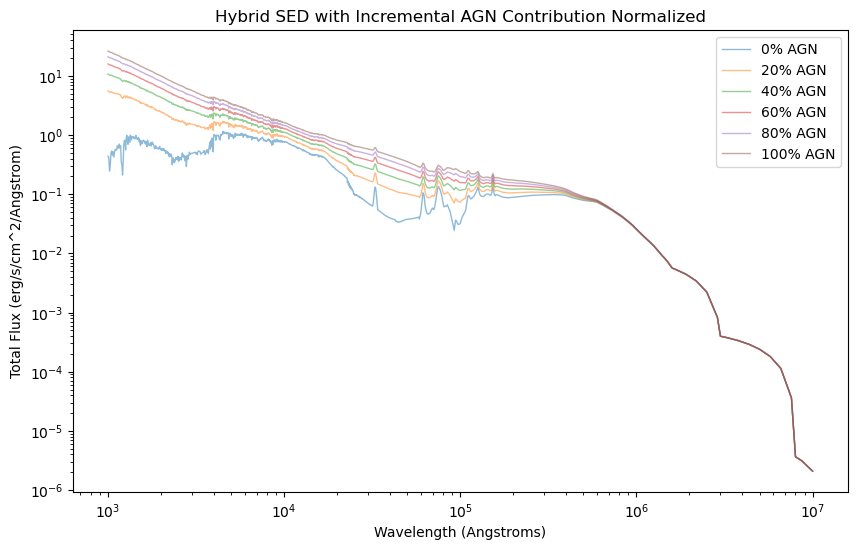

In [126]:
# Creating many composites
composites = []
for a in alpha:
    print(f'Creating composite with alpha = {a}')
    composite_galaxy = create_gal_agn_composite_sed(agn_model, m82_template, a)
    composites.append(composite_galaxy)

# Plotting the adjusted SEDS
plt.figure(figsize=(10, 6))
for i, comp in enumerate(composites):
    wl_comp = comp['lambda (Angstroms)']
    fl_comp = comp['Total Flux (erg/s/cm^2/Angstrom)']
    plt.loglog(wl_comp, fl_comp, linewidth=1, linestyle='-', alpha=0.5, label=f'{round(alpha[i]*100)}% AGN')
plt.legend()
plt.title("Hybrid SED with Incremental AGN Contribution Normalized")
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Total Flux (erg/s/cm^2/Angstrom)')